<h1 style="text-align: center">
Deep Learning HW3 </br>
VAE and CVAE
</h1>


### Full Name: Ahmad Karami Fathabadi
### Student ID: 401205756

# Import necessary libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision
from sklearn.manifold import TSNE
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Define the MNIST dataset and data loader

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Data Visualization

In [4]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

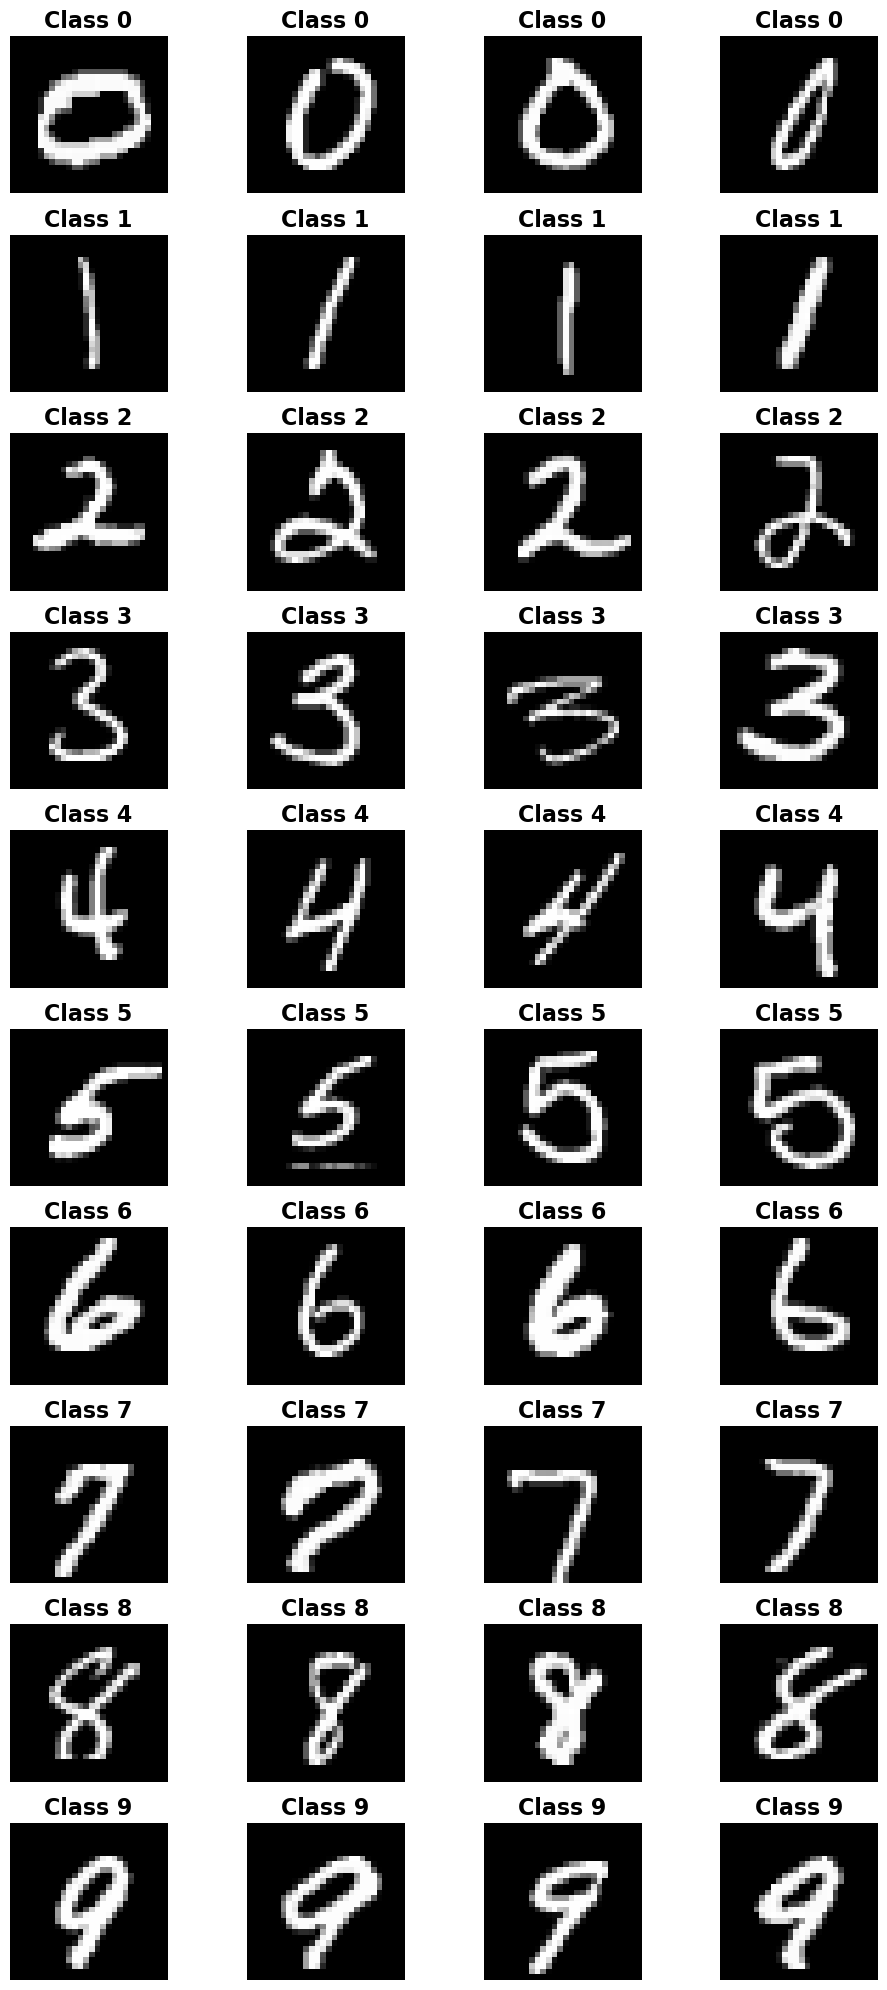

In [5]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [6]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # Implement the reparameterization trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        # Implement the forward pass
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [7]:
def vae_loss(recon, data, mu, logvar):
    # Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Return the total loss as the sum of reconstruction and KL divergence losses
    return reconstruction_loss + kl_divergence


In [8]:
def vae_img_show(model):
  with torch.no_grad():
      num_samples = 6
      sample = torch.randn(num_samples, 20)
      sample = model.decoder(sample).view(num_samples, 1, 28, 28)
      sample = sample.squeeze().to(device)
      # print(2)
      fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
      for i in range(num_samples):
          # print(3)
          axs[i].imshow(sample[i].cpu(), cmap='gray')
          axs[i].axis('off')
      plt.show()

In [9]:
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        # Show sample images before each epoch
        print(f"Sample Images in Epoch{epoch}:")
        vae_img_show(model)
        print()
        print(100 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # Forward process
            data = data.view(data.size(0), -1)
            recon, mu, logvar = model(data)

            # Flatten the data and recon tensors
            data = data.view(data.size(0), -1)
            recon = recon.view(recon.size(0), -1)

            # Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()


    # Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")


Sample Images in Epoch0:


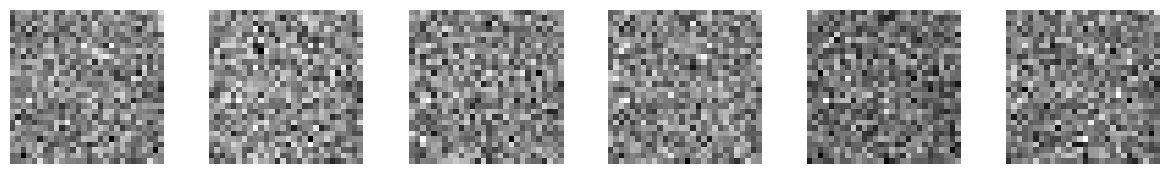


####################################################################################################
VAE-MLP Epoch [1/10], Loss: 156.2469393676758
Sample Images in Epoch1:


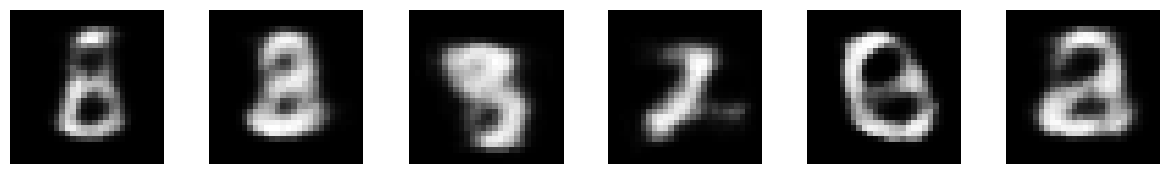


####################################################################################################
VAE-MLP Epoch [2/10], Loss: 120.39991193847656
Sample Images in Epoch2:


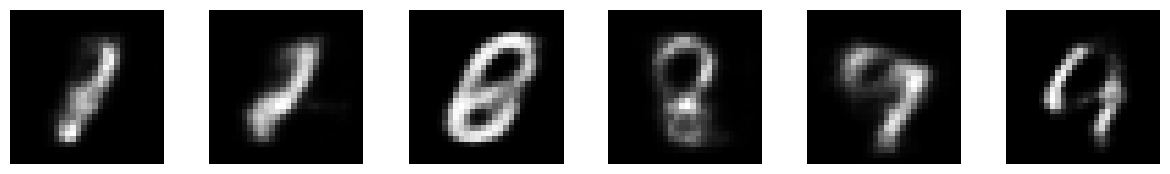


####################################################################################################
VAE-MLP Epoch [3/10], Loss: 113.42788426920573
Sample Images in Epoch3:


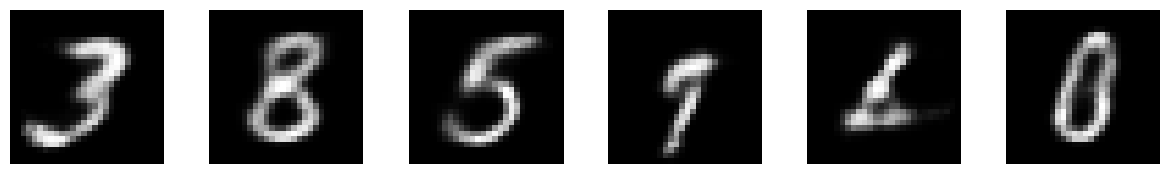


####################################################################################################
VAE-MLP Epoch [4/10], Loss: 109.97246292317708
Sample Images in Epoch4:


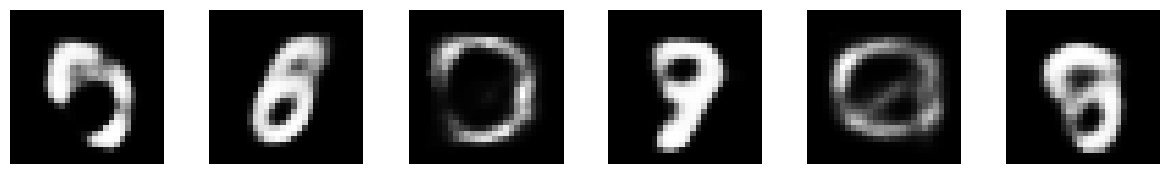


####################################################################################################
VAE-MLP Epoch [5/10], Loss: 107.71319364420573
Sample Images in Epoch5:


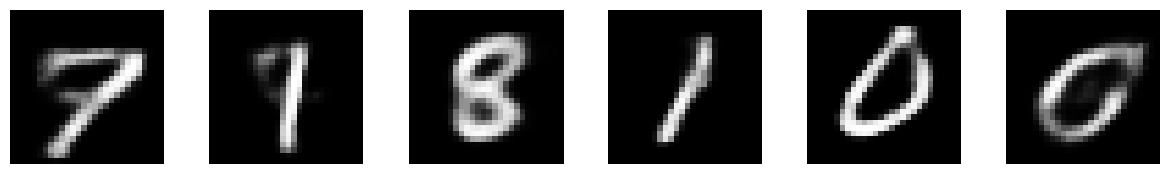


####################################################################################################
VAE-MLP Epoch [6/10], Loss: 106.12208408610026
Sample Images in Epoch6:


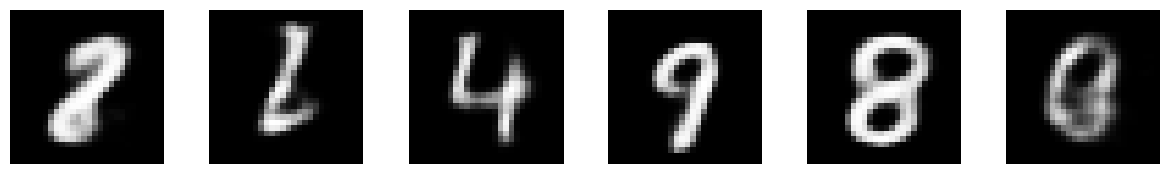


####################################################################################################
VAE-MLP Epoch [7/10], Loss: 104.96300209960937
Sample Images in Epoch7:


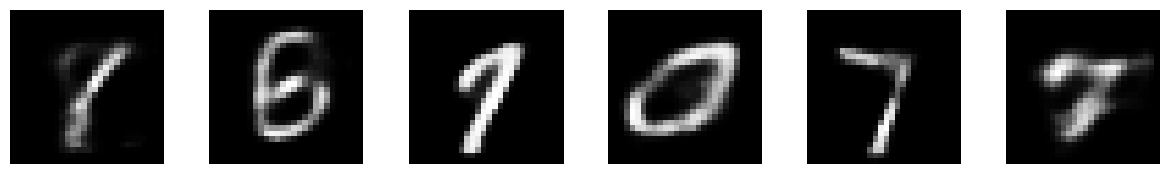


####################################################################################################
VAE-MLP Epoch [8/10], Loss: 104.09697926839193
Sample Images in Epoch8:


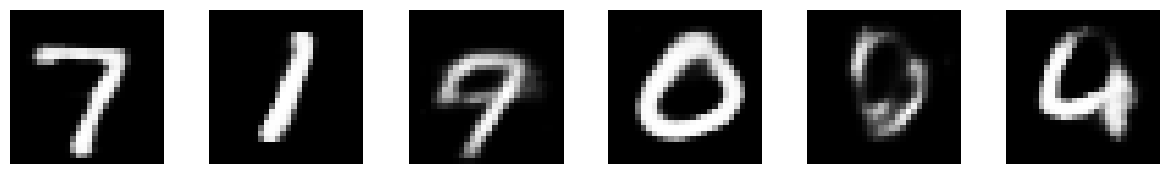


####################################################################################################
VAE-MLP Epoch [9/10], Loss: 103.46230321044922
Sample Images in Epoch9:


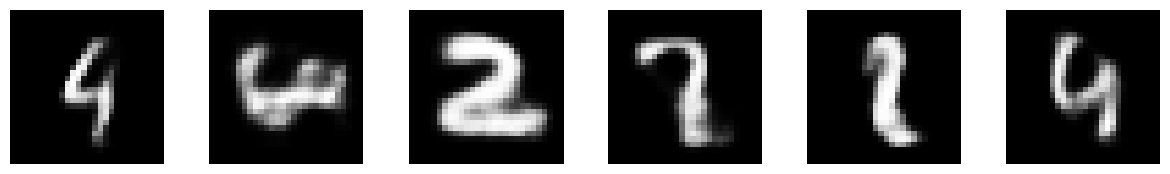


####################################################################################################
VAE-MLP Epoch [10/10], Loss: 102.9505030069987
Best model saved as 'best_vae_mlp_model.pth'


In [10]:
# Train VAE-MLP

input_dim = 784  # input images are 28x28 pixels
hidden_dim = 400
latent_dim = 20

vae_mlp = VAE_MLP(input_dim, hidden_dim, latent_dim)
train_vae_mlp(vae_mlp, train_loader)


# 2) CVAE --> MLP

In [10]:
class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        x = torch.cat((x, y), dim=1)

        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)

        z = torch.cat((z, y), dim=1)
        reconstructed = self.decoder(z)

        return reconstructed, mu, logvar, class_logits


In [11]:
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # Flatten the data tensor
    data = data.view(data.size(0), -1)

    # Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Implement the cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels)

    # Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return reconstruction_loss + kl_divergence + ce_loss


In [12]:
def cvae_img_show(model):
  with torch.no_grad():
     num_classes = 10
     num_samples_per_class = 1
     # Generate random samples
     z = torch.randn(num_classes * num_samples_per_class, 20)
     # Generate one-hot encoded class labels
     y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
     # Concatenate the random samples and class labels before passing them to the decoder
     sample = torch.cat([z, y], dim=1)
     sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
     sample = sample.squeeze().to(device)
     fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
     for i in range(num_classes):
         axs[i].imshow(sample[i].cpu(), cmap='gray')
         axs[i].set_title(f"Class {i}", fontsize=16)
         axs[i].axis('off')
     plt.show()

In [13]:
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        # Show sample images before each epoch
        print(f"Sample Images in Epoch{epoch}:")
        cvae_img_show(model)
        print()
        print(100 * "#")
        total_loss = 0

        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10)

            # Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)

            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()


    # Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")


Sample Images in Epoch0:


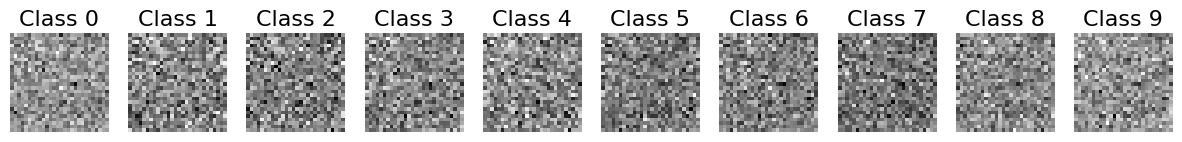


####################################################################################################
CVAE-MLP Epoch [1/10], Loss: 149.55352220865885
Sample Images in Epoch1:


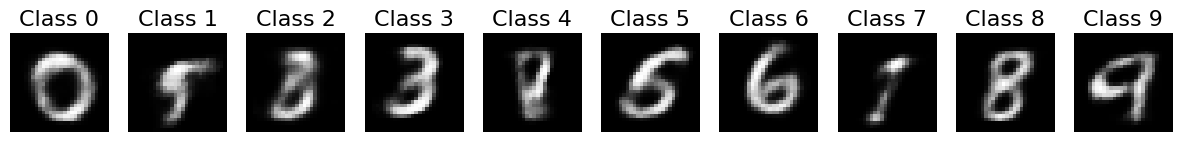


####################################################################################################
CVAE-MLP Epoch [2/10], Loss: 114.89554844970704
Sample Images in Epoch2:


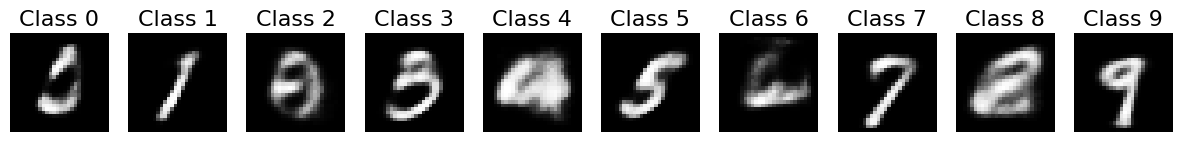


####################################################################################################
CVAE-MLP Epoch [3/10], Loss: 108.5511446492513
Sample Images in Epoch3:


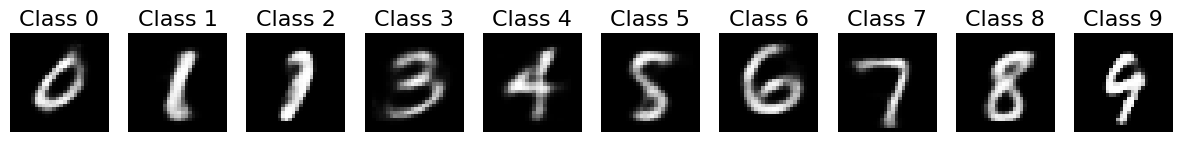


####################################################################################################
CVAE-MLP Epoch [4/10], Loss: 105.5480802734375
Sample Images in Epoch4:


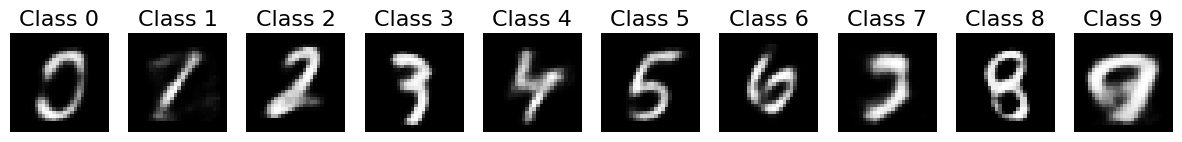


####################################################################################################
CVAE-MLP Epoch [5/10], Loss: 103.49784117838541
Sample Images in Epoch5:


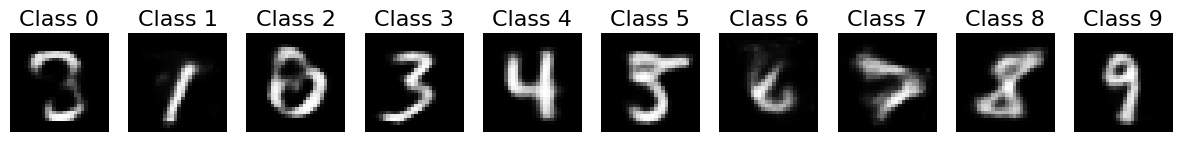


####################################################################################################
CVAE-MLP Epoch [6/10], Loss: 102.09644123942057
Sample Images in Epoch6:


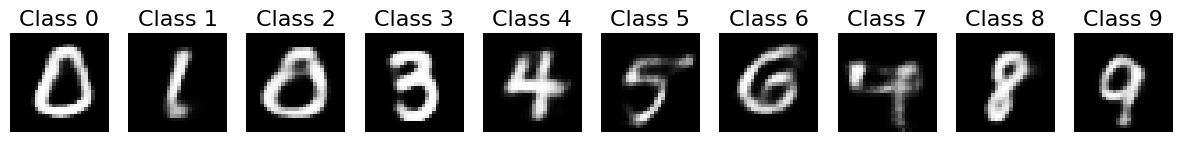


####################################################################################################
CVAE-MLP Epoch [7/10], Loss: 100.90758606770834
Sample Images in Epoch7:


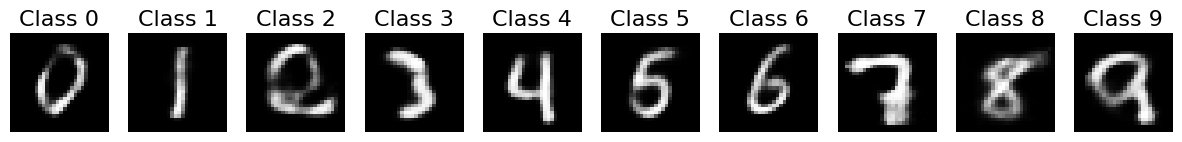


####################################################################################################
CVAE-MLP Epoch [8/10], Loss: 100.03539111328125
Sample Images in Epoch8:


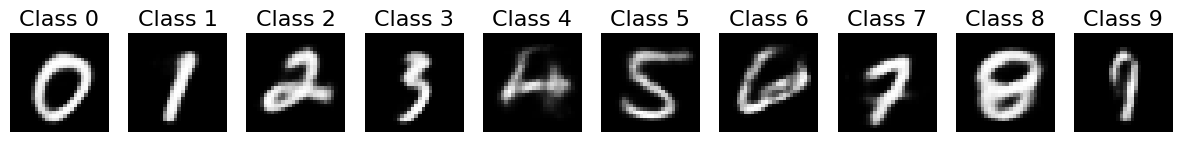


####################################################################################################
CVAE-MLP Epoch [9/10], Loss: 99.28465456136068
Sample Images in Epoch9:


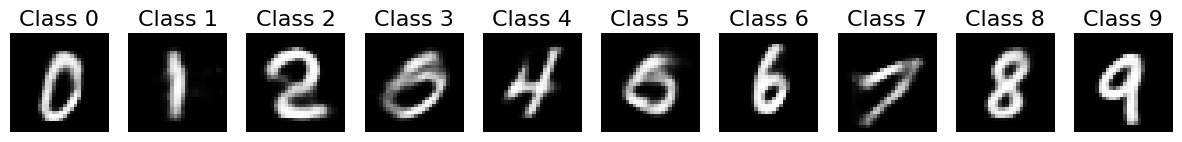


####################################################################################################
CVAE-MLP Epoch [10/10], Loss: 98.72185361735026
Best model saved as 'best_cvae_mlp_model.pth'


In [14]:
# Train CVAE-MLP
input_dim = 784  # input images are 28x28 pixels
hidden_dim = 400
latent_dim = 20
num_classes = 10

cvae_mlp = CVAE_MLP(input_dim, hidden_dim, latent_dim, num_classes)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


In [26]:
def visualize_latent_space(model, data_loader, mode):
    model.eval()
    z_values = []
    label_values = []

    with torch.no_grad():
        for i, (data, labels) in enumerate(data_loader):
            data = data.view(data.size(0), -1)
            if mode == 'CVAE':
                labels_one_hot = F.one_hot(labels, num_classes=10)
                _, mu, logvar, _ = model(data, labels_one_hot)
            elif mode == 'VAE':
                _, mu, logvar = model(data)

            z = model.reparameterize(mu, logvar)
            z = z.detach().numpy()
            z_values.append(z)
            label_values.extend(labels.tolist())
            if i == 100: break

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    z_values = np.concatenate(z_values)
    z_values_TSNE = TSNE(n_components=2).fit_transform(z_values)


    axs[0].scatter(z_values[:, 0], z_values[:, 1], c=label_values, cmap='viridis')
    axs[0].set_title(f"Original Latent Variables in {mode}")

    axs[1].scatter(z_values_TSNE[:, 0], z_values_TSNE[:, 1], c=label_values, cmap='viridis')
    axs[1].set_title(f"Latent Variables in {mode} Transformed by t-SNE")
    plt.show()


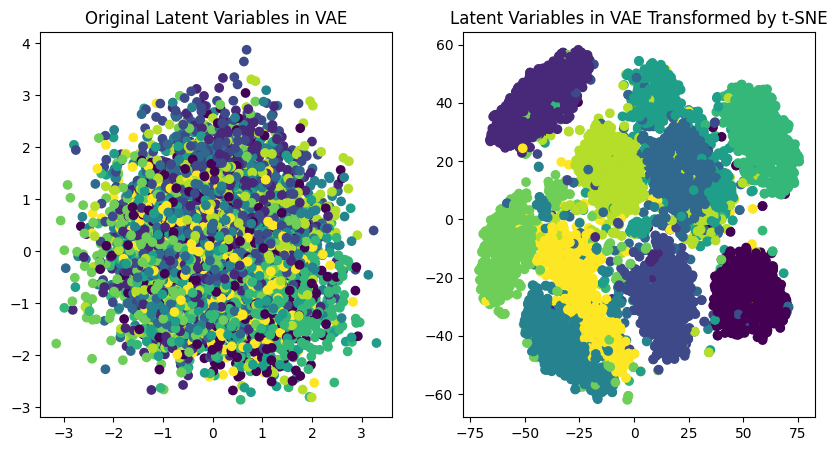

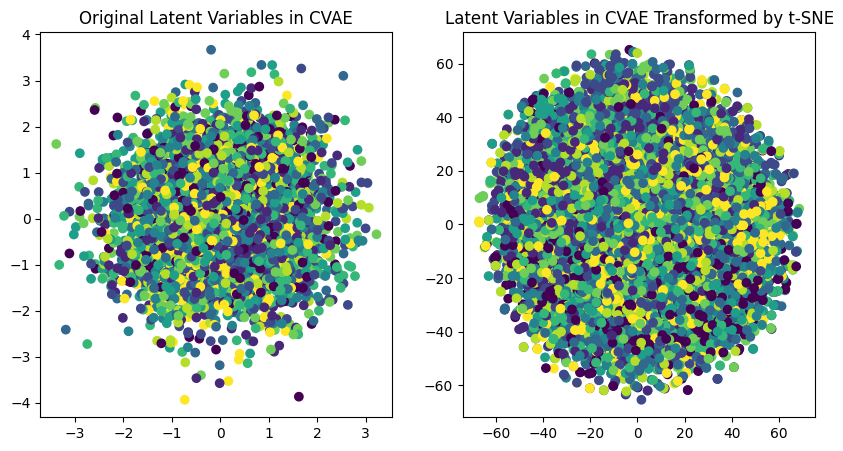

In [27]:
visualize_latent_space(vae_mlp, train_loader,'VAE')
visualize_latent_space(cvae_mlp, train_loader, 'CVAE')

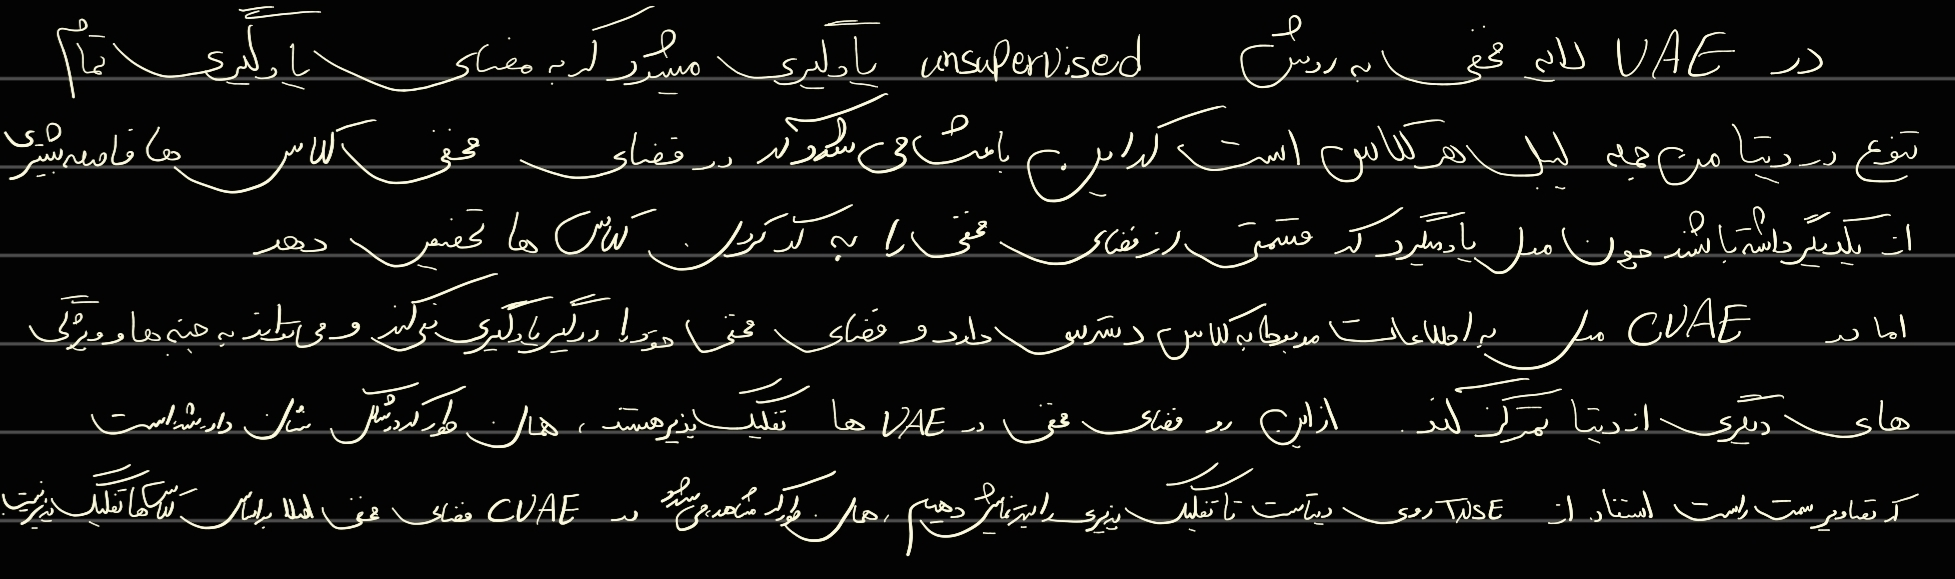